In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using CSV
using LaTeXStrings
using Printf
using DataFrames
#using Distributions
using LsqFit
using Markdown
using Printf
import YAML
using Statistics


  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
using PythonCall
mpl=pyimport("matplotlib")
#mpl.use("Agg")
mpl.use("svg")
#mpl.use("module://juliacall.matplotlib") #some workaround for inline plotting
plt=pyimport("matplotlib.pyplot")
ccrs=pyimport("cartopy.crs")

Python module: <module 'cartopy.crs' from '/Users/huntemann/SeaIceThickness_ATBD/sit_atbd_env_jl/.CondaPkg/env/lib/python3.10/site-packages/cartopy/crs.py'>

In [3]:
all_regions_locs=
[  7.6849991e+001,  4.2563492e+001],
[  7.8344194e+001,  4.7455311e+001],
[  7.8714499e+001,  5.7407954e+001],
[  7.8378661e+001,  6.6654149e+001],
[  7.8337631e+001,  7.4859558e+001],
[  7.7374017e+001,  8.1712057e+001],
[  7.5811001e+001,  7.9569564e+001],
[  7.4850015e+001,  6.9278851e+001],
[  7.3124055e+001,  6.1770532e+001],
[  7.1849906e+001,  6.0701303e+001]

([76.849991, 42.563492], [78.344194, 47.455311], [78.714499, 57.407954], [78.378661, 66.654149], [78.337631, 74.859558], [77.374017, 81.712057], [75.811001, 79.569564], [74.850015, 69.278851], [73.124055, 61.770532], [71.849906, 60.701303])

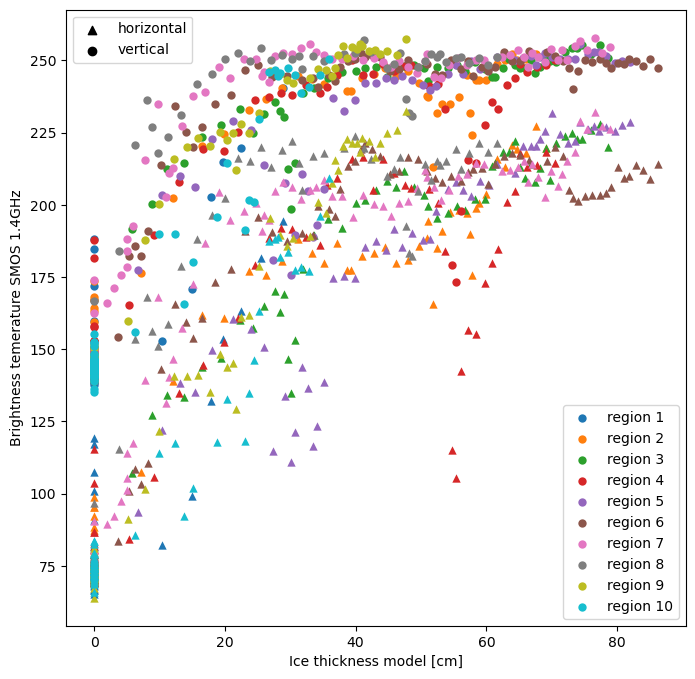

In [4]:
airt=CSV.read("../data/sit_ncep.txt",DataFrame,limit=87)
all_regions_dfs=Dict{Int64,DataFrame}()
#plot(size=(800,600))
regions=1:10
for i=regions
#    @show @sprintf "../data/region%02i_53.txt" i
    all_regions_dfs[i]=CSV.read((@sprintf "../data/region%02i_53_724.txt" i),DataFrame)
end


fig=plt.figure(figsize=[8,8])
ax=fig.add_subplot(111)
cmap = plt.get_cmap("tab10")
litems=[]
lnames=[]
for i=regions
    p1=ax.scatter(airt[!,"region$i"],all_regions_dfs[i].TBh,marker="^",lw=0,color=cmap(i-1),label="")#L"region %$i $T_{b,h}")
   push!(litems,ax.scatter(airt[!,"region$i"],all_regions_dfs[i].TBv,marker="o",lw=0,color=cmap(i-1),label="region $i"))
    push!(lnames,"region $i")
end
#plt.c
#plot!(legend=:bottomright)
#plot!(legendfontsize=10)
ax.set_xlabel("Ice thickness model [cm]")
ax.set_ylabel("Brightness temerature SMOS 1.4GHz")
leg1=ax.legend(litems,lnames,loc="lower right")

leg2=ax.legend([ax.scatter([],[],marker=d,color="black") for d in "^o"],["horizontal","vertical"],loc="upper left")
fig.add_artist(leg1)

#ax.twinx()
#ax.tw
#scatter!([1],[0],marker=:utriangle,color="black",label=L"$T_{b,h}$")
#scatter!([1],[0],marker=:circ,color="black",label=L"$T_{b,v}$")
#ylims!(50,260)
display(fig)

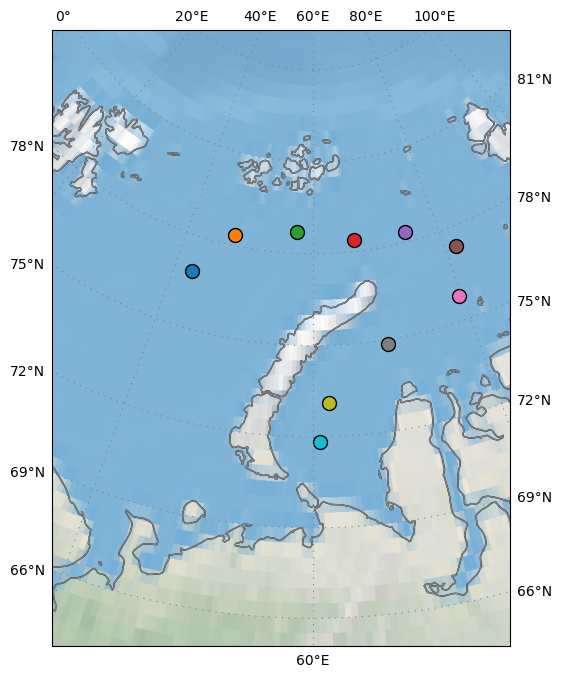

In [5]:
mycrs=ccrs.LambertAzimuthalEqualArea(central_latitude=90,central_longitude=60)
fig=plt.figure(figsize=[8,8])
ax=fig.add_subplot(111,projection=mycrs)
ax.coastlines()
ax.gridlines(draw_labels=true,color="gray",linestyle=(0, (1, 5,)))
ax.set_extent((40,75,65,85),crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines("50m",color="gray")
for i=regions
ax.plot(all_regions_locs[i][2],all_regions_locs[i][1],lw=0,marker="o",transform=ccrs.PlateCarree(),mec="black",ms=10)
end
fig

In [6]:
alltbh=collect(skipmissing(vcat([all_regions_dfs[i].TBh for i=regions]...)))
nanidx=isnan.(alltbh)

alltbv=collect(skipmissing(vcat([all_regions_dfs[i].TBv for i=regions]...)))
allsit=vcat([airt[!,"region$i"] for i=regions]...);


#nanidx.|=(allsit.==0)


alltbh=alltbh[.!nanidx]
alltbv=alltbv[.!nanidx]
allsit=allsit[.!nanidx];

In [7]:
@. ff(x,p)=p[2]-(p[2]-p[1])*exp(-x/p[3])
@. fq(x,p)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])
ph=curve_fit(ff,allsit,alltbh,[70.0,200.0,0.12]).param
pv=curve_fit(ff,allsit,alltbv,[70.0,200.0,0.12]).param
pI=curve_fit(ff,allsit,alltbh./2+alltbv./2,[70.0,200.0,0.12]).param
pQ=curve_fit(fq,allsit,alltbv.-alltbh,[70.0,20.0,0.12,0.4]).param
t(n)=@sprintf "%.3f" n

"""```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| polarization\\parameter | \$p_1\$ | \$p_2\$ | \$p_3\$ | \$p_4\$ |
| --- | --- | --- | --- | --- | 
| horizontal \$T_{b,h}\$ | $(t(ph[1])) | $(t(ph[2])) | $(t(ph[3])) |   |
| vertical \$T_{b,v}\$| $(t(pv[1])) | $(t(pv[2])) | $(t(pv[3])) |    |
| intensity \$I=(T_{b,v}+T_{b,h})/2\$| $(t(pI[1])) | $(t(pI[2])) | $(t(pI[3])) |    |
| polarization difference \$Q=(T_{b,v}-T_{b,h})\$| $(t(pQ[1])) | $(t(pQ[2])) | $(t(pQ[3])) | $(t(pQ[4])) | 
""" * "```"|> Markdown.parse 

```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| polarization\parameter | $p_1$ | $p_2$ | $p_3$ | $p_4$ |
| --- | --- | --- | --- | --- | 
| horizontal $T_{b,h}$ | 74.527 | 217.795 | 21.021 |   |
| vertical $T_{b,v}$| 145.170 | 247.636 | 12.509 |    |
| intensity $I=(T_{b,v}+T_{b,h})/2$| 109.891 | 231.596 | 16.829 |    |
| polarization difference $Q=(T_{b,v}-T_{b,h})$| 71.086 | 34.322 | 38.731 | 2.142 | 
```


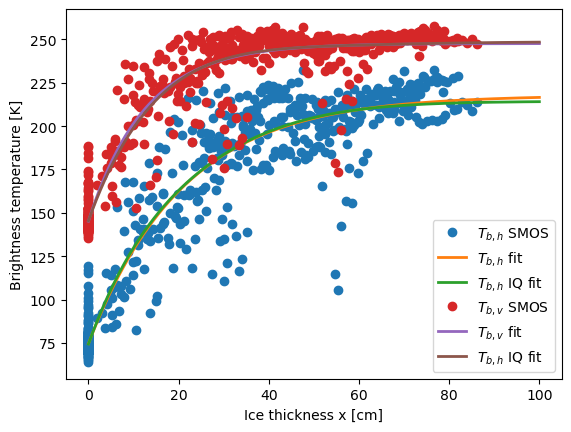

In [8]:
xx=0:0.1:100.0

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(allsit,alltbh,lw=0,marker="o",label=L"$T_{b,h}$ SMOS")
ax.plot(xx,ff(xx,ph),lw=2,label=L"$T_{b,h}$ fit")
ax.plot(xx,ff(xx,pI).-fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")

ax.plot(allsit,alltbv,lw=0,marker="o",label=L"$T_{b,v}$ SMOS")
ax.plot(xx,ff(xx,pv),lw=2,label=L"$T_{b,v}$ fit")
ax.plot(xx,ff(xx,pI).+fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")
ax.legend(loc="lower right")

ax.set_xlabel("Ice thickness x [cm]")
ax.set_ylabel("Brightness temperature [K]")
fig

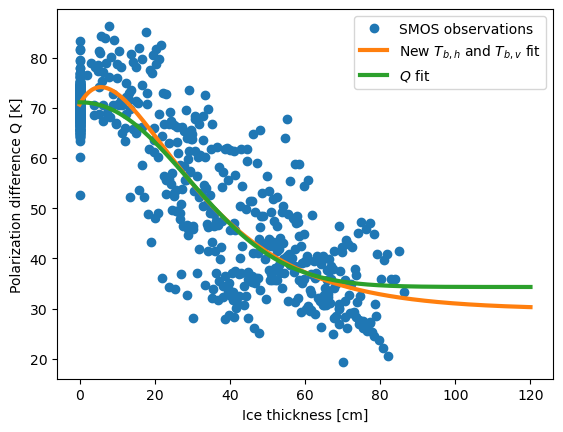

In [9]:
xx=0:0.01:120
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(allsit,alltbv.-alltbh,lw=0,marker="o", label="SMOS observations")
ax.plot(xx,ff(xx,pv).-ff(xx,ph),lw=3,label=L"New $T_{b,h}$ and $T_{b,v}$ fit")
ax.plot(xx,fq(xx,pQ),lw=3,label=L"$Q$ fit")

ax.set_ylabel("Polarization difference Q [K]")
ax.set_xlabel("Ice thickness [cm]")
ax.legend()
fig

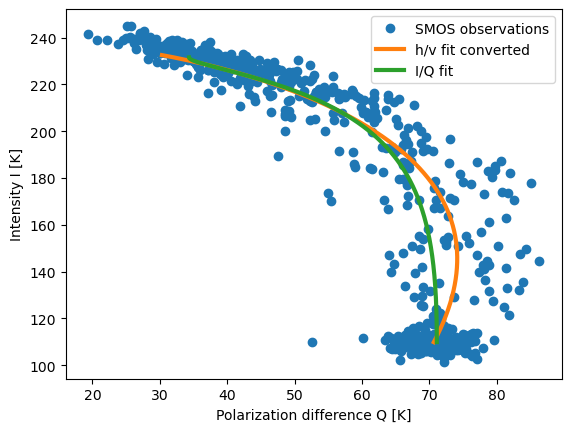

In [10]:
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(alltbv.-alltbh,alltbv./2 +alltbh./2,lw=0,marker="o",label="SMOS observations")
ax.plot(ff(xx,pv).-ff(xx,ph),ff(xx,pv)./2 .+ff(xx,ph)./2,lw=3,label="h/v fit converted")
ax.plot(fq(xx,pQ),ff(xx,pI),lw=3,label="I/Q fit")

ax.set_xlabel("Polarization difference Q [K]")
ax.set_ylabel("Intensity I [K]")
ax.legend()
fig

In [11]:
YAML.write_file("fit_params.yml", Dict("ph"=>ph,"pv"=>pv, "pI"=>pI, "pQ"=>pQ))